# Automating Data Management

## Story and benefit of Python

NOAA releases many web services to pull weather and climate data from. One is the Global Historical Climate Network daily values dataset (GHCND). We want to record the precipitation values of interest in a table for each weather station, and keep a hosted feature layer in ArcGIS Online up to date with the most recent precipitation values to implement into our GIS web maps and apps. 

To do this without Python:
- Use a graphical user interface from the service provider.
- You manually submit a request for each weather station of interest.
- You engineer the data to ensure it is in the proper format, for each table.
- You append the record(s) from the downloaded CSV file to the respective geodatabase table.
- You look at the precipitation values on the day of interest and manually edit the hosted feature layer, for each weather station. You have 100+ stations.
- You repeat this on-demand for your team.

To do this with Python:
- Use the <code>requests</code> library to access data of interest.
- Use the <code>json</code> library to represent the data in a transferable file format.
- Use the <code>pandas</code> library and built-in python functionality to engineer the data consistently.
- Use the <code>os</code> library to generate filepaths.
- Use the <code>time</code> library to count how long a process takes.
- use the <code>arcgis</code> library (ArcGIS API for Python) to search for and the hosted feature layer into the map.
- Use the <code>arcpy</code> library to:.
 - Generate create a table for each weather station.
 - Add the value precipitation value to the appropriate table.
 - Update the precipitation value in the hosted feature layer.
 
By combining <code>arcpy</code> and <code>arcgis</code> with built-in Python functionality and open source python libraries, you can automate all of the steps in this process. This ensures the process is completed with out error and in significantly less time.

## Prepare the notebook for the task

### Import libraries

In [1]:
%reset -f
import requests
import json
import pandas as pd
import os
import time
from arcgis import GIS
import arcgis

### Access a web layer using the ArcGIS API for Python

With the ArcGIS API for Python, your GIS is represented through <code>arcgis.GIS()</code>. This provides access to content and members for the ArcGIS Online or Enterprise organization.

In [2]:
gis = GIS('Pro')

<code>gis.content.search()</code> let's you search for and access content in your portal.

<Item title:"GHCNDStations" type:Feature Layer Collection owner:tkinlaw_EsriEdDelivery>
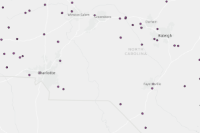

In [3]:
searchResults = gis.content.search(query="title:GHCND Stations", item_type = "Feature Layer")
display(searchResults[0])

Returned is a feature layer collection. Using the <code>[0]</code> at the end of <code>searchResults[0].layers[0]</code> grabs the first feature layer in this collection, which is the weather stations layer.

In [4]:
featureLayer = searchResults[0].layers[0]

<code>arcpy.mp</code> provides tools to automate project management and mapping functionality. The code below does the following:
- <code>arcpy.mp.ArcGISProject("CURRENT")</code> provides a reference to the opened ArcGIS Pro project, stored in the <code>aprx</code> variable.
- <code>aprx.listMaps("GH Climate Network")[0]</code> reads all the map names in the project, and represents the one map titled 'GH Climate Network".<code></code>
- <code>[lyr.name for lyr in ghcndMap.listLayers()]</code> generates a list of layer names
- The <code>if-else</code> statement adds the feature layer to the map if it is not already in the map.

In [5]:
aprx = arcpy.mp.ArcGISProject("CURRENT")
ghcndMap = aprx.listMaps("GH Climate Network")[0]
lyrNames = [lyr.name for lyr in ghcndMap.listLayers()]

if "GHCNDStations" not in lyrNames:
    ghcndMap.addDataFromPath(featureLayer.url)
    print(f"The {featureLayer.properties.name} layer has been added to the {ghcndMap.name} map")
else:
    print(f"The {featureLayer.properties.name} layer is already in the {ghcndMap.name} map")

The GHCNDStations layer has been added to the GH Climate Network map


This web layer (<code>GHCNDStations</code>) will be used for two tasks:
- First, we will use a selection tool to select stations that we want the updated values for.
- Second, later in the script, we will update the precipitation value for each station using the information acquired through the <code>requests</code> library.

## Access data from a NOAA web service

### Generate a request for select stations

The <code>requests</code> library uses a python <code>string</code> to submit a request the server. We will interact with the results in JSON format. We then use the <code>json</code> liibrary to extract just the data in a transferable file format. Then, we convert the json data into a <code>pandas</code> DataFrame. A <code>pandas</code> DataFrame is a powerful python class for slicing, dicing, querying, and manipulating data in tabular form.

Typing out the request manually is time-consuming and challenging. In line 5 of this code, you will see <code>stationid=</code>. This is where you would type out the name of each weather station. This is burdensome.

Instead of typing out the stationids manually, we will use <code>arcpy.da.SearchCursor</code> to extract the names of the weather stations for us based on our layer selection in an ArcGIS Pro map.
- When using Notebooks in ArcGIS Pro, you can work directly with the layers in a map.
- Selections are honored when using layers in a map.
- You can use the selection tools to generate the list for you, prior to running the cell below .
- If no selection is present, all weather stationids will be used.
- The syntax for the request requires that each <code>stationid</code> is seperated by a comma. 
- The Python <code>string</code> method <code>join()</code> places a comma between each <code>stationid</code>.

In [6]:
lyr = 'GHCNDStations'
layerSrc = arcpy.da.SearchCursor(lyr, "STATION_ID")
listNames = ','.join([row[0] for row in layerSrc])
del layerSrc
print(listNames)

date = '2022-06-15'

r = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&stationid=' + listNames + '&startdate=' + date + '&enddate=' + date + '', headers={'token':"VuErdRKUcmflRtQQoDtKcetOXataWGfD"})
j = json.dumps(r.json()['results'], indent=5)
df = pd.read_json(j).drop(['attributes'],axis=1)
df.head(10)

GHCND:USC00318906,GHCND:USC00314996,GHCND:USC00317618,GHCND:USC00311538,GHCND:USW00053878,GHCND:USC00313976,GHCND:USW00053872,GHCND:USC00315771,GHCND:USC00313152,GHCND:USC00316805,GHCND:USC00314764,GHCND:USW00053870,GHCND:USC00314997,GHCND:USW00013881,GHCND:USC00311975,GHCND:USC00312574,GHCND:USW00003812,GHCND:USC00318744,GHCND:USC00317845


,date,datatype,station,value
0,2022-06-15,PRCP,GHCND:USC00311538,0
1,2022-06-15,PRCP,GHCND:USC00311975,20
2,2022-06-15,PRCP,GHCND:USC00312574,0
3,2022-06-15,PRCP,GHCND:USC00313152,0
4,2022-06-15,PRCP,GHCND:USC00313976,5
5,2022-06-15,PRCP,GHCND:USC00314764,13
6,2022-06-15,PRCP,GHCND:USC00314996,0
7,2022-06-15,PRCP,GHCND:USC00314997,38
8,2022-06-15,PRCP,GHCND:USC00315771,15
9,2022-06-15,PRCP,GHCND:USC00316805,76


### Engineering the data

We will perform common data engineering tasks to extract the useful data from this web service. The code below will:
- Explore our data by seeing how many weather stations we have data for.
 - <code>df['station']</code> provides just name of weather stations.
 - The <code>unique()</code> method returns the distinct name of weather stations, removing any duplicates.
 - The Python built-in function <code>len()</code> returns the number of unique stations returned by the <code>unique()</code> method.
- Ensure we only have <code>PRCP</code> values (as opposed to other weather variables).
- Convert the numeric value from millimeters to inches (divide mm by 25.4).
 - Store the new values in a new field, <code>values_inches</code>.
 - Round the values to simply the data using <code>round()</code>.
 - Drop the original field, <code>values</code> now that we have a new field, <code>value_inches</code>.
 
 When engineering data in python, you are often working with a representation of your data. You can engineer the data however you like, and not affect the source data itself. This enables you to quickly test code without the risk of unintended edits.

In [7]:
print(f"You are working with {len(df['station'].unique())} weather stations")

You are working with 19 weather stations


In [8]:
df.drop(df.loc[df['datatype']!="PRCP"].index, inplace=True)
df['value_inches'] = round(df['value']/25.4, 5)
df.drop(columns='value', inplace=True)
df.head(10)

,date,datatype,station,value_inches
0,2022-06-15,PRCP,GHCND:USC00311538,0.00000
1,2022-06-15,PRCP,GHCND:USC00311975,0.78740
2,2022-06-15,PRCP,GHCND:USC00312574,0.00000
3,2022-06-15,PRCP,GHCND:USC00313152,0.00000
4,2022-06-15,PRCP,GHCND:USC00313976,0.19685
5,2022-06-15,PRCP,GHCND:USC00314764,0.51181
6,2022-06-15,PRCP,GHCND:USC00314996,0.00000
7,2022-06-15,PRCP,GHCND:USC00314997,1.49606
8,2022-06-15,PRCP,GHCND:USC00315771,0.59055
9,2022-06-15,PRCP,GHCND:USC00316805,2.99213


## Integrate the NOAA web service data into a geodatabase table

### Create a unique table for each station

We have a feature layer of the weather stations of interest. We need a table for each weather station to hold the weather data.
- We will generate a list of the weather stations we want tables for
- Then create a table for each weather station, unless there is an existing one

#### Generate a list of all the weather stations from the feature class

<code>arcpy.da.SearchCursor()</code> is used to read the data from the web layer. As we read each feature, extract the name of the weather stations in the data for later use.

In [13]:
targetGDB = r"C:\Demos\UC2023\PythonAutomation\GHCN_Tables.gdb"

src = arcpy.da.SearchCursor(lyr, "Station_ID")

stationList = []
for row in src:
    stationName = row[0][6:]
    stationList.append(stationName)

#### Create a table for each station with fields for: station name, date, and value

We will use the <code>arcpy.EnvManager()</code> to temporarily apply these environment settings: 
- <code>addOutputsToMap = False</code>prevents outputs from being added to the map, since we are potentially creating dozens of tables.
- <code>workspace = targetGDB</code> points <code>arcpy</code> to where our weather station tables are.

While using these environment settings we:
- Use <code>os.path.join()</code> to stitch together a valid filepath to the table being processed.
- Use <code>arcpy.Exists()</code> to see if the table already exists. 
- Using built-in Python functionality, conditionally run code using the <code>if-else statement</code>.
 - If the station is already a table (the data does exist), then just <code>print</code> that this is the case.
 - Otherwise (should the table not exist), create the table and add fields to it.

In [14]:
with arcpy.EnvManager(addOutputsToMap = False, workspace = targetGDB):
    for station in stationList:
        newTable = os.path.join(targetGDB, station)
        if arcpy.Exists(station):
            print(f"This station already has a table: {station}")
        else:
            arcpy.management.CreateTable(targetGDB, station)
            arcpy.management.AddFields(newTable, [["Precipitation", "FLOAT", "Precipitation (inches)"], ["Date", "DATE"]])
            print(f"Table created for station: {station}")
print("Tables for weather stations verified")

This station already has a table: USC00318906
This station already has a table: USC00314996
This station already has a table: USC00317618
This station already has a table: USC00311538
Table created for station: USW00053878
This station already has a table: USC00313976
Table created for station: USW00053872
This station already has a table: USC00315771
This station already has a table: USC00313152
This station already has a table: USC00316805
This station already has a table: USC00314764
This station already has a table: USW00053870
This station already has a table: USC00314997
This station already has a table: USW00013881
This station already has a table: USC00311975
This station already has a table: USC00312574
This station already has a table: USW00003812
This station already has a table: USC00318744
This station already has a table: USC00317845
Tables for weather stations verified


#### Add the data from the service to the respective table and transform the data to reflect inches of precipitation.

Functionality shown:
- Using <code>time.time()</code> enables us to track how long the process takes
- Iterate over every weather station in our list
- Use <code>zip()</code> to efficiently iterate over each row in the <code>df</code> dataframe, and have variables (<code>s</code>, <code>v</code>, <code>d</code>) to call upon cell values
- Use <code>arcpy.da.InsertCursor()</code> to add new records to the table

In [15]:
start = time.time()
for s, v, d in zip(df['station'], df['value_inches'], df['date']):
    print(f"{s} {v} {d}")
    for station in stationList:
        if station in s:
            targetTable = os.path.join(targetGDB, station)
            iCur = arcpy.da.InsertCursor(targetTable, ["Precipitation", "Date"])
            iCur.insertRow([v, d])
            print(f"Data added to: {station} from {s}\n")
            del iCur
end = time.time()
print(f"Adding the records to each table took: {round(end-start, 5)} seconds")

GHCND:USC00311538 0.0 2022-06-15 00:00:00
Data added to: USC00311538 from GHCND:USC00311538

GHCND:USC00311975 0.7874 2022-06-15 00:00:00
Data added to: USC00311975 from GHCND:USC00311975

GHCND:USC00312574 0.0 2022-06-15 00:00:00
Data added to: USC00312574 from GHCND:USC00312574

GHCND:USC00313152 0.0 2022-06-15 00:00:00
Data added to: USC00313152 from GHCND:USC00313152

GHCND:USC00313976 0.19685 2022-06-15 00:00:00
Data added to: USC00313976 from GHCND:USC00313976

GHCND:USC00314764 0.51181 2022-06-15 00:00:00
Data added to: USC00314764 from GHCND:USC00314764

GHCND:USC00314996 0.0 2022-06-15 00:00:00
Data added to: USC00314996 from GHCND:USC00314996

GHCND:USC00314997 1.49606 2022-06-15 00:00:00
Data added to: USC00314997 from GHCND:USC00314997

GHCND:USC00315771 0.59055 2022-06-15 00:00:00
Data added to: USC00315771 from GHCND:USC00315771

GHCND:USC00316805 2.99213 2022-06-15 00:00:00
Data added to: USC00316805 from GHCND:USC00316805

GHCND:USC00317618 0.0 2022-06-15 00:00:00
Data 

## Update a hosted feature layer in ArcGIS Online

We have a hosted feature layer in ArcGIS Online. On an on-demand basis, we want this layer to reflect these new temperature values. To keep this service light, we only want one record for each station, and one attribute field for precipitation values.
- Use the <code>arcgis</code> library (ArcGIS API for Python) to access the service.
- Update the precipitation value for each weather station.

To do this manually, you would:
- Bring the web layer in to a map in ArcGIS Pro
- Open the attribute table for the web layer
- For each feature in the web layer:
 - Locate the associated table in the geodatabase
 - Copy the precipitation value
 - Paste the precipitation value in the web layer (make sure you are on the right feature!)

We need to compile a list of files paths to the tables storing the weather data. As we iterate over the stations in the web layer, update the recent precipitation value to the web layer.
- <code>arcpy.ListTables()</code> function will create a list of the tables in a workspace. This will be all tables, regardless of our selection from earlier.
- We will conver the list of all weather station tables to a Python <code>set</code>. This data type enables us to easily extract the commonalities between the list of all tables and the list of weather stations from the selection.
- Then, convert the <code>set</code> back to a <code>list</code> so we can iterate over it using a <code>for</code> loop.

In [16]:
allTablesList = arcpy.ListTables()
tablesList = list(set(allTablesList).intersection(stationList))
print(tablesList)

['USC00315771', 'USC00314996', 'USW00053872', 'USC00316805', 'USC00314764', 'USC00313152', 'USW00013881', 'USW00003812', 'USW00053878', 'USC00317618', 'USC00317845', 'USW00053870', 'USC00312574', 'USC00318906', 'USC00318744', 'USC00311538', 'USC00311975', 'USC00314997', 'USC00313976']


In [17]:
updatesMade = 0

sFieldsList=[]
[sFieldsList.append(field.name) for field in arcpy.ListFields(tablesList[0]) if field.type != "OID" ]

uFieldsList=['STATION_ID', 'RecentPRCPInches']
uCur = arcpy.da.UpdateCursor(featureLayer.properties.name, uFieldsList)

for uRow in uCur:
    for station in tablesList:
        if uRow[0][6:] == station:
            srcTable = arcpy.da.SearchCursor(station, sFieldsList)
            for sRow in srcTable:
                pass
            # We only want the last edit/law record. So, iterate over all records in the search cursor. Then, use that last value (uRow)
            updatesMade+=1
            uRow[1] = round(sRow[0], 3)
            print(f"{uRow[0][6:]} precipitation value set to {uRow[1]}")
            uCur.updateRow(uRow)
            del srcTable
del uCur
print(f"There were {updatesMade} stations updated. \nDone.")

USC00318906 precipitation value set to 4.016
USC00314996 precipitation value set to 0.0
USC00317618 precipitation value set to 0.0
USC00311538 precipitation value set to 0.0
USW00053878 precipitation value set to 0.0
USC00313976 precipitation value set to 0.197
USW00053872 precipitation value set to 0.0
USC00315771 precipitation value set to 0.591
USC00313152 precipitation value set to 0.0
USC00316805 precipitation value set to 2.992
USC00314764 precipitation value set to 0.512
USW00053870 precipitation value set to 0.0
USC00314997 precipitation value set to 1.496
USW00013881 precipitation value set to 0.0
USC00311975 precipitation value set to 0.787
USC00312574 precipitation value set to 0.0
USW00003812 precipitation value set to 0.0
USC00318744 precipitation value set to 0.512
USC00317845 precipitation value set to 6.299
There were 19 stations updated. 
Done.
